ta


# Modelització

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn import preprocessing

In [2]:
from sklearn.model_selection import train_test_split,  KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, f1_score, explained_variance_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [3]:
st_songs = pd.read_csv('standarized_songs.csv', index_col=0)

*** QUEDA FER ESCALAT CORRECTE AMB EL X_TRAIN I Y_TRAIN ***

### Training i test split

In [9]:
X = st_songs.drop(columns = {'popularity'}).iloc[:,2:]
y = st_songs['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model Lineal

In [10]:
# We instantiate a linear regression. 
lr = LinearRegression()

# Now we train it on train data with fit method
lr.fit(X_train,y_train)

# We can predict using the predict method
y_pred = lr.predict(X_train)

weights = lr.coef_
intercept = lr.intercept_
# You can access to some info about the model, like the weights.
print('Coeficients')
for x, y in zip(X.columns, weights[:]):
    print(x, y)
print('Intercept: \n', intercept)

Coeficients
track_number -0.012789366309592758
acousticness 0.005238372324209678
danceability -0.02179810733184065
energy 0.025724008231123745
liveness -0.004727928459368625
loudness 0.07527253933331042
tempo -0.026382557838695808
valence 0.020018070867257338
duration 0.04913998827196136
taylors_version 0.07609417165403644
performed_live -0.18474302031148165
not_first_release -0.07537170126581451
low_instrumentalness -0.011284737927421594
medium_instrumentalness -0.009083307494508332
spoken_section -0.015492947281437042
Live From Clear Channel Stripped 2008 -0.11413639453469111
Taylor Swift -0.06119650471325041
Speak Now (Taylor's Version) 0.01683226309335387
1989 -0.05686544859567671
Speak Now -0.11015515292915105
reputation Stadium Tour Surprise Song Playlist -0.0943001403108766
Red (Taylor's Version) 0.010046500081230994
evermore 0.09847607054483558
Fearless (Taylor's Version) -0.01571955301391503
Midnights 0.14209210362992078
folklore 0.07448180169231186
Fearless -0.154942076059055

In [11]:
### Molt important veure quins són els pesos dels coeficients 'album', ja que quan predim no en posarem ###

album_weights = weights[15:]

for x, y in zip(X.columns[15:], album_weights):
    print(x, y)
print('Intercept: \n', intercept)


Live From Clear Channel Stripped 2008 -0.11413639453469111
Taylor Swift -0.06119650471325041
Speak Now (Taylor's Version) 0.01683226309335387
1989 -0.05686544859567671
Speak Now -0.11015515292915105
reputation Stadium Tour Surprise Song Playlist -0.0943001403108766
Red (Taylor's Version) 0.010046500081230994
evermore 0.09847607054483558
Fearless (Taylor's Version) -0.01571955301391503
Midnights 0.14209210362992078
folklore 0.07448180169231186
Fearless -0.1549420760590557
Red -0.16294044983410474
1989 (Taylor's Version) 0.06493496149336742
Speak Now World Tour Live 0.023693514534082506
Lover 0.1714643414095329
reputation 0.1682341635120864
Intercept: 
 0.5940256357830579


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, 'Live From Clear Channel Stripped 2008'),
  Text(1, 0, 'Taylor Swift'),
  Text(2, 0, "Speak Now (Taylor's Version)"),
  Text(3, 0, '1989'),
  Text(4, 0, 'Speak Now'),
  Text(5, 0, 'reputation Stadium Tour Surprise Song Playlist'),
  Text(6, 0, "Red (Taylor's Version)"),
  Text(7, 0, 'evermore'),
  Text(8, 0, "Fearless (Taylor's Version)"),
  Text(9, 0, 'Midnights'),
  Text(10, 0, 'folklore'),
  Text(11, 0, 'Fearless'),
  Text(12, 0, 'Red'),
  Text(13, 0, "1989 (Taylor's Version)"),
  Text(14, 0, 'Speak Now World Tour Live'),
  Text(15, 0, 'Lover'),
  Text(16, 0, 'reputation')])

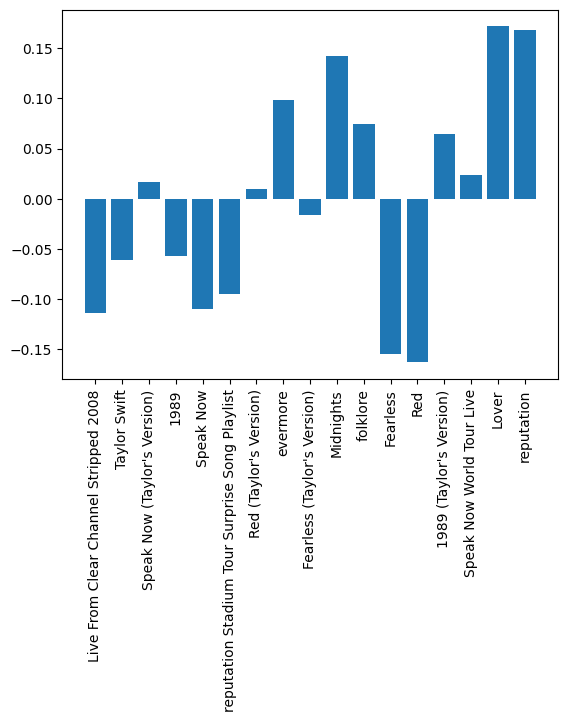

In [12]:
plt.bar(X.columns[15:], album_weights)
plt.xticks(rotation=90)

Veiem que els àlbums més recents (Midnights, evermore, folklore, Lover)...

362    0.015427
56     0.075635
203   -0.035110
272    0.000570
435    0.021085
         ...   
71    -0.027932
106   -0.049720
270    0.073793
438    0.005459
102   -0.010368
Name: popularity, Length: 395, dtype: float64


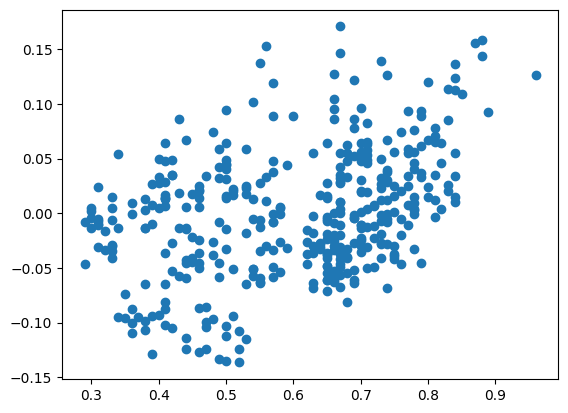

In [13]:
naive_prediction_error = y_train - y_pred
print(naive_prediction_error)

plt.scatter(y_train, naive_prediction_error)
plt.show()

In [14]:
mse = mean_squared_error(y_train, y_pred)
mse

0.003368510829257281

In [15]:
R_squared = r2_score(y_train, y_pred)
norm_mse_sk = 1 - R_squared
norm_mse_sk, R_squared


(0.14893040156029014, 0.8510695984397099)

Cross validation

In [16]:
from sklearn.model_selection import LeaveOneOut

N = len(X_train)

lr_cv = LinearRegression()
lr_cv.fit(X_train, y_train)
folds_r2 = cross_val_score(lr_cv, X_train, y_train, cv = 10, scoring='r2')
lr_r2 = np.mean(folds_r2)
print(lr_r2)
print(folds_r2)

0.8248614543729408
[0.80725982 0.84153015 0.84190578 0.80317552 0.81869733 0.89415637
 0.80165964 0.7462441  0.90533758 0.78864825]


Veiem que el model lineal de moment explica molta variablitat.

#### Regularització

Ridge:

In [17]:
lambdas = [1e-10,1e-5, 1e-4,1e-4,1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.5, 0.7, 0.8, 1, 2, 10, 100, 200]

In [21]:
ridge_cv = RidgeCV(alphas=lambdas, cv = 10)
ridge_cv.fit(X_train, y_train)
print('Best Lambda:', ridge_cv.alpha_)
print('R2 SCORE: ', ridge_cv.best_score_)

Best Lambda: 0.3
R2 SCORE:  0.8255419258432374


In [22]:
abs(ridge_cv.coef_ - lr.coef_)

array([0.00014781, 0.00073744, 0.0019579 , 0.00428171, 0.00017739,
       0.01619019, 0.00039551, 0.00301753, 0.01054862, 0.0009237 ,
       0.00406092, 0.000327  , 0.00182455, 0.00105122, 0.00161002,
       0.00899433, 0.00395356, 0.00245931, 0.00068846, 0.00478543,
       0.00067601, 0.00031872, 0.00258547, 0.00072539, 0.00481954,
       0.00208346, 0.00376589, 0.00183016, 0.00257973, 0.00425739,
       0.00472573, 0.00579393])

No hi ha hagut massa diferència

#### Lasso

Ridge:

In [23]:
lambdas = [1e-10,1e-5, 1e-4,1e-4,1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.5, 0.7, 0.8, 1, 2, 10, 100, 200]

In [24]:
lasso_cv = LassoCV(alphas=lambdas, cv = 10)
lasso_cv.fit(X_train, y_train)
print('Best Lambda:', lasso_cv.alpha_)
lasso_r2 = r2_score(y_train, lasso_cv.predict(X_train))
print('R2 SCORE: ', lasso_r2)

Best Lambda: 0.0001
R2 SCORE:  0.8503547295953455


C:\Users\mique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03133378952442001, tolerance: 0.0008015717183098591
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004694876642117318, tolerance: 0.000792597915492958
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:664: Conv

In [27]:
abs(lasso_cv.coef_ - lr.coef_)

array([3.45647758e-05, 1.75126936e-03, 6.27301426e-03, 2.50047783e-03,
       4.27929118e-04, 2.04588091e-02, 3.53532239e-03, 7.47391502e-03,
       2.06162226e-02, 2.71495001e-02, 1.19000041e-02, 7.07960812e-04,
       1.12847379e-02, 9.08330749e-03, 1.24760879e-02, 4.47746179e-02,
       2.22858107e-02, 9.03368995e-03, 1.64019981e-02, 2.16619401e-02,
       3.14940820e-02, 1.00465001e-02, 1.16575454e-02, 8.30165657e-03,
       6.73237561e-03, 1.26774229e-02, 1.92075648e-02, 1.70535842e-02,
       1.54209004e-02, 2.49204788e-02, 9.65468211e-03, 8.61427141e-03])

No hi ha hagut massa diferència

## Random forest

In [26]:
rf = RandomForestRegressor(oob_score=True)
model_rf = rf.fit(X_train, y_train)

y_pred_tree = model_rf.predict(X_train)

print(r2_score(y_train, y_pred_tree))
print(mean_squared_error(y_train, y_pred_tree))
print(1 - r2_score(y_train, y_pred_tree))


print('OOB accuracy=', model_rf.oob_score_)

0.9645964833036277
0.0008007574554027066
0.03540351669637232
OOB accuracy= 0.8147247664486079


MOLT baix error -> Però segurament és degut a overfitting (salt entre r2_score i OOB score)
La precisió pel OOB set és bastant bona, però.

Podriem afegir GridSearch (tant al DecisionTree com al RandomForest) !

### GridSearch per Decision Tree

Anem a veure si un Decision Tree SOL és capaç de fer una bona regressió.

10 folds CV

In [65]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Define the parameter grid for grid search
param_grid = {
    'max_depth': [8, 9, 10, 11, 12],  # values around 10
    'min_samples_split': [2, 3, 4, 5, 6],  # values around 4
    'min_samples_leaf': [5, 6, 7, 8, 9],  # values around 7
    'max_features': ['sqrt', 'log2', None]  # including None as it was the best in the previous run
}

scoring = {
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Create a decision tree regressor
dt = DecisionTreeRegressor(random_state=42)

# Create the grid search object
grid_search = GridSearchCV(dt, param_grid, cv=10, scoring=scoring, refit='r2', return_train_score=True, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)  

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create a new decision tree with the best parameters
best_dt = DecisionTreeRegressor(random_state=42,**best_params)

# Fit the new decision tree to the training data
best_dt.fit(X_train, y_train)

# Predict using the new decision tree
y_pred_best_decision_tree = best_dt.predict(X_test)

In [66]:
print(r2_score(y_test, y_pred_best_decision_tree))

0.8079011419812345


In [64]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
    'mean_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'mean_test_r2'
]

pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_r2', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_r2
139,9,6,7,None,-0.051023,-0.004565,0.792858
135,9,2,7,None,-0.051023,-0.004565,0.792858
136,9,3,7,None,-0.051023,-0.004565,0.792858
137,9,4,7,None,-0.051023,-0.004565,0.792858
138,9,5,7,None,-0.051023,-0.004565,0.792858


5 folds CV

In [60]:

# Create a decision tree regressor
dt = DecisionTreeRegressor(random_state=42)

# Create the grid search object
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring=scoring, refit='r2', return_train_score=True, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)  

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create a new decision tree with the best parameters
best_dt = DecisionTreeRegressor(random_state=42,**best_params)

# Fit the new decision tree to the training data
best_dt.fit(X_train, y_train)

# Predict using the new decision tree
y_pred_best_dt = best_dt.predict(X_test)

In [61]:
print(r2_score(y_test, y_pred_best_dt))

0.7948712700031756


In [ ]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
    'mean_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'mean_test_r2'
]

pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_r2', ascending=False)[scoring_cols].head()

Un bon decision tree! Quasi el 80% de la variància explicada per ambdós nivell de folds. És bàsicament tant bo com el RF sense Grid Search.

Coses a veure: hi ha poc overfitting perquè el r2 mitjà de la CV és quasi igual al de r2 de generalització?

In [ ]:
# best parameters

# param_grid = {
#     'max_depth': [9],
#     'min_samples_split': [2, 3, 4, 5, 6],
#     'min_samples_leaf': [7],
#     'max_features': [None]
# }

### GridSearch per Random Forest

In [74]:
param_grid = {
    'n_estimators': [10,100,200],
    'max_depth': [8, 9, 10, 11, 12],  # values around 10
    'min_samples_split': [2, 3, 4, 5, 6],  # values around 4
    'min_samples_leaf': [5, 6, 7, 8, 9],  # values around 7
    'max_features': ['sqrt', 'log2', None]  # including None as it was the best in the previous run
}

scoring = {
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Create a decision tree regressor
rf = RandomForestRegressor(random_state=42)

# Create the grid search object
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring=scoring, refit='r2', return_train_score=True, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)  

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create a new decision tree with the best parameters
best_rf = RandomForestRegressor(random_state=42,**best_params)

# Fit the new decision tree to the training data
best_rf.fit(X_train, y_train)

# Predict using the new decision tree
y_pred_best_rf = best_rf.predict(X_test)

In [78]:
print(r2_score(y_test, y_pred_best_rf))

0.794732675124019


In [87]:
best_rf.n_estimators

100

In [84]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
    'mean_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'mean_test_r2'
]

pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_r2', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_r2
705,12,4,5,None,-0.051248,-0.004426,0.800313
703,12,3,5,None,-0.051248,-0.004426,0.800313
701,12,2,5,None,-0.051248,-0.004426,0.800313
709,12,6,5,None,-0.051248,-0.004426,0.800313
707,12,5,5,None,-0.051248,-0.004426,0.800313
